<a href="https://colab.research.google.com/github/amirsartipi13/NSURL/blob/main/TestBertOnPERELEX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML flow

In [ ]:
!pip install mlflow --quiet

import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = input('amirjustjoin')
os.environ['MLFLOW_TRACKING_PASSWORD'] = getpass('8b1a9ff702faf9c769072f2fff3fbaef3f6634fa')
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = input('relation-extraction')

mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] 
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

amirjustjoinamirjustjoin
8b1a9ff702faf9c769072f2fff3fbaef3f6634fa··········
relation-extractionrelation-extraction


In [ ]:
# See your experiments table inside Colab!
import IPython
display(IPython.display.IFrame("https://dagshub.com/"+ os.environ['MLFLOW_TRACKING_USERNAME'] 
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + "/experiments/#/",'100%',600))

# Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install hazm

     |████████████████████████████████| 316 kB 8.4 MB/s 
     |████████████████████████████████| 1.4 MB 63.4 MB/s 
     |████████████████████████████████| 233 kB 63.5 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394487 sha256=24ca22c8f5ee8cc9c562d3726fbb27906390ad9b27431afb1333f254ec29704c
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=153790 sha256=6dce3f3d0a5b9102f22960a305fd26335f7816510215c2c90f8a155d30d4444f
  Stored in directory: /root/.cache/pip/wheels/ab/b2/5b/0fe4b8f5c0e65341e8ea7bb3f4a6ebabfe8b1ac31322392dbf
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 9.5 MB/s 
     |████████████████████████████████| 895 kB 55.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.5 MB/s 


In [ ]:
import re
import pandas as pd

import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification


from __future__ import unicode_literals
from hazm import *

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  

# pre define functions


In [ ]:
from sklearn.metrics import f1_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    tt = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {indx2label[label]}')
        print("Acc with percent:", len(y_preds[y_preds==label])/len(y_true))
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        tt += len(y_preds[y_preds==label])/len(y_true)
    return tt/ len(label2index)


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        # inputs = {'input_ids':      batch[0],
        #           'attention_mask': batch[1],
        #           'labels':         batch[2],
        #          }


        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  # XLM and RoBERTa don't use segment_ids
                  # 'token_type_ids': batch[2],
                  'e1_mask': batch[2],
                  'e2_mask': batch[3],
                  'labels':  batch[4],

                  }
        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    

# Prepare English Dataset




In [ ]:
def make_dataframe(path):
    f = open(path, 'r')
    data = [x.rstrip() for x in f] 
    data_set_rows = []
    # labels_file = open("perlex_labels.txt", "w")
    # sentences_file = open("perlex_sentences.txt", "w")
    clean_sentences = []
    for i in range(0, len(data)-4, 4):
      item = data[i].split('\t')
      sentence = re.sub('[!@#$،.()]', '', item[1])

      label = data[i+1]

      # labels_file.write(label)
      # labels_file.write('\n')

      # sentences_file.write(sentence)
      # sentences_file.write('\n')

      rows, clean_sentence= make_dataframe_row(sentence , label)
      data_set_rows += rows
      clean_sentences.append(clean_sentence)
    return pd.DataFrame(data_set_rows)

# Model Class

In [ ]:
import torch
import torch.nn.functional as F
from transformers import WEIGHTS_NAME, BertConfig, BertModel, BertPreTrainedModel, BertTokenizer
from torch.nn import MSELoss, CrossEntropyLoss

In [ ]:
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        # self.bert = AutoModelForSequenceClassification.from_pretrained(config.model_name, config.num_labels)
        self.cls_dropout = torch.nn.Dropout(0.1)  # dropout on CLS transformed token embedding
        self.ent_dropout = torch.nn.Dropout(0.1)  # dropout on average entity embedding
        
        self.classifier = torch.nn.Linear(config.hidden_size*3, self.config.num_labels)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, e1_mask=None, e2_mask=None, labels=None,
                position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        # for details, see https://huggingface.co/transformers/model_doc/bert.html#bertmodel
        pooled_output = outputs[1]  # sequence of hidden-states at the output of the last layer of the model
        sequence_output = outputs[0]  # last layer hidden-state of the first token of the sequence (classification token) further processed by a Linear layer and a Tanh activation function.

        def extract_entity(sequence_output, e_mask):
            # print('extract_entity')
            extended_e_mask = e_mask.unsqueeze(1)
            extended_e_mask = torch.bmm(
                extended_e_mask.float(), sequence_output).squeeze(1)
            return extended_e_mask.float()

        e1_h = self.ent_dropout(extract_entity(sequence_output, e1_mask))
        e2_h = self.ent_dropout(extract_entity(sequence_output, e2_mask))
        context = self.cls_dropout(pooled_output)
        pooled_output = torch.cat([context, e1_h, e2_h], dim=-1)

        logits = self.classifier(pooled_output)

        # add hidden states and attention if they are here
        outputs = (logits,) + outputs[2:]

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                # print('loss ottt')
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
                
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [ ]:
train_path = './drive/MyDrive/data_sets/PERLEX/train.txt'
test_path = './drive/MyDrive/data_sets/PERLEX/test.txt'
train_path_e = './drive/MyDrive/data_sets/PERLEX/train_english.txt'
test_path_e = './drive/MyDrive/data_sets/PERLEX/test_english.txt'

# train_path = './drive/MyDrive/dataset/perlex/train.txt'
# test_path = './drive/MyDrive/dataset/perlex/test.txt'

In [ ]:
def get_e1(text):
  text = re.sub('[E21]', '', text)
  text = re.sub('[E22]', '', text)
  e = re.findall("[E11](.*?)[E12]", text)
  pre_process = set()
  for ent in e:
    if ent != ' ' and len(ent.strip())>1:
      pre_process.add(ent.strip())
  return list(pre_process)

In [ ]:
def get_e2(text):
  text = re.sub('[E11]', '', text)
  text = re.sub('[E12]', '', text)
  e = re.findall("[E21](.*?)[E22]", text)
  pre_process = set()
  for ent in e:
    if ent != ' ' and len(ent.strip())>1:
      pre_process.add(ent.strip())
  return list(pre_process)

In [ ]:
SEMEVAL_RELATION_LABELS = ['Other', 'Message-Topic(e1,e2)', 'Message-Topic(e2,e1)',
                   'Product-Producer(e1,e2)', 'Product-Producer(e2,e1)',
                   'Instrument-Agency(e1,e2)', 'Instrument-Agency(e2,e1)',
                   'Entity-Destination(e1,e2)', 'Entity-Destination(e2,e1)',
                   'Cause-Effect(e1,e2)', 'Cause-Effect(e2,e1)',
                   'Component-Whole(e1,e2)', 'Component-Whole(e2,e1)',
                   'Entity-Origin(e1,e2)', 'Entity-Origin(e2,e1)',
                   'Member-Collection(e1,e2)', 'Member-Collection(e2,e1)',
                   'Content-Container(e1,e2)', 'Content-Container(e2,e1)']

In [ ]:
indx2label = dict(enumerate(SEMEVAL_RELATION_LABELS))


In [ ]:
label2index = {v:k for k,v in indx2label.items()}

In [ ]:
# model_name = 'bert-base-multilingual-cased'
# model_name = 'xlm-roberta-large'
# model_name = 'xlm-roberta-base'

model_name = 'HooshvareLab/bert-fa-zwnj-base'


config = {
    "model_name":model_name,
    "num_labels": len(label2index),
    "max_length": 85
}

In [ ]:

tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
special_tokens_dict = {'additional_special_tokens': ['[E11]','[E12]','[E21]','[E22]']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

In [ ]:
normilizer = Normalizer(persian_numbers=False, token_based=True)

In [ ]:
def process_sentence(sentence):
  sentence = normilizer.normalize(sentence)
  sentence = sentence.replace('<e1>','[E11]').replace('</e1>','[E12]').replace('<e2>','[E21]').replace('</e2>','[E22]')
  # stemmer = Stemmer()
  # stemmer = stemmer.stem(sentence)
  # words = word_tokenize(sentence)
  return sentence

In [ ]:
def get_e1p(text):
    sentence = tokenizer.tokenize(text)
    E11_p = [i+2 for i, e in enumerate(sentence) if e == '[E11]']
    E12_p = [i for i, e in enumerate(sentence) if e == '[E12]']
    return zip(E11_p, E12_p)

In [ ]:
def get_e2p(text):
  sentence = tokenizer.tokenize(text)
  E21_p = [i+2 for i, e in enumerate(sentence) if e == '[E21]']
  E22_p = [i for i, e in enumerate(sentence) if e == '[E22]']
  return zip(E21_p, E22_p)

In [ ]:
def label_spliter(label):
  # component-whole(e2,e1)
  # return [whole , component ]
  order = re.findall("\((.*?)\)", label)[0].split(',')
  label_names = label.split("(")[0].split("-")
  if order[0] == "e1":
    return label_names
  else:
    return list(reversed(label_names))

def make_dataframe_row(sentence,label):
    
  if label == "Other":
    labels =[label, label]
  else:
    labels = label_spliter(label=label)

  result = []
  clean_sentence = process_sentence(sentence)
  # e1s = get_e1(clean_sentence)  
  # e2s = get_e2(clean_sentence)
  e1s_p = get_e1p(clean_sentence)
  e2s_p = get_e2p(clean_sentence)

  for e11, e12 in e1s_p:
    for e21, e22 in e2s_p:
      result.append({
          # "e1":e1s[e1],
          # "e2":e2s[e2],
          "e1_label":labels[0],
          "e2_label":labels[1],
          "label":label,
          "e1_start":e11,
          "e1_end":e12,
          "e2_start":e21,
          "e2_end":e22,
          "nlabel": label2index[label],
          "sentence": clean_sentence
      })
  return result
    
def make_dataframe(path):
    f = open(path, 'r')
    data = [x.rstrip() for x in f] 
    data_set_rows = []
    labels_file = open("perlex_labels.txt", "w")
    sentences_file = open("perlex_sentences.txt", "w")
    clean_sentences = []
    for i in range(0, len(data)-4, 4):
      item = data[i].split('\t')
      sentence = re.sub('[!@#$،.()]', '', item[1])

      label = data[i+1]

      # labels_file.write(label)
      # labels_file.write('\n')

      # sentences_file.write(sentence)
      # sentences_file.write('\n')

      rows = make_dataframe_row(sentence , label)
      data_set_rows += rows
    return pd.DataFrame(data_set_rows)

In [ ]:
df = make_dataframe(train_path)
df_test = make_dataframe(test_path)
df_english = make_dataframe(train_path_e)
df_test_english = make_dataframe(test_path_e)



df = df.sample(frac=1).reset_index(drop=True)
df_english = df_english.sample(frac=1).reset_index(drop=True)

# df_test = df_test.sample(frac=1).reset_index(drop=True)

**get english dataset entity**

In [ ]:
X_train_english = df_english.sentence.tolist()
X_train_e1_se_english = zip(df_english.e1_start.tolist() , df_english.e1_end.tolist())
X_train_e2_se_english = zip(df_english.e2_start.tolist() , df_english.e2_end.tolist())
y_train_english = df_english.nlabel.tolist()

In [ ]:
X_val_english =  df_test_english.sentence.tolist()
X_val_e1_se_english = zip(df_test_english.e1_start.tolist() , df_test_english.e1_end.tolist())
X_val_e2_se_english = zip(df_test_english.e2_start.tolist() , df_test_english.e2_end.tolist())
y_val_english =  df_test_english.nlabel.tolist()

**get persian dataset entity**

In [ ]:
X_train = df.sentence.tolist()
X_train_e1_se = zip(df.e1_start.tolist() , df.e1_end.tolist())
X_train_e2_se = zip(df.e2_start.tolist() , df.e2_end.tolist())
y_train = df.nlabel.tolist()


X_val =  df_test.sentence.tolist()
X_val_e1_se = zip(df_test.e1_start.tolist() , df_test.e1_end.tolist())
X_val_e2_se = zip(df_test.e2_start.tolist() , df_test.e2_end.tolist())
y_val =  df_test.nlabel.tolist()

In [ ]:
configuration = BertConfig()
configuration.num_labels = len(label2index)

In [ ]:
# model  = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2index))
model = BertForSequenceClassification.from_pretrained(config['model_name'], num_labels=len(label2index))
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at HooshvareLab/bert-fa-zwnj-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/b

Embedding(42004, 768)

In [ ]:
model.config

BertConfig {
  "_name_or_path": "HooshvareLab/bert-fa-zwnj-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_15": 15,
    "LABEL_16": 16,
    "LABEL_17": 17,
    "LABEL_18": 18,
    "LABEL_2": 2,
    "LABEL

In [ ]:
df['len_sentence'] = df['sentence'].apply(lambda t: len(tokenizer.tokenize(t)))
print(df['len_sentence'].max())
print(df['len_sentence'].min())

117
10


In [ ]:
df_test['len_sentence'] = df_test['sentence'].apply(lambda t: len(tokenizer.tokenize(t)))
print(df_test['len_sentence'].max())
print(df_test['len_sentence'].min())

83
10


In [ ]:
# Finding the share of comments with a specific length
def data_gl_than(data, less_than=100.0, greater_than=0.0, col='len_sentence'):
    data_length = data[col].values

    data_glt = sum([1 for length in data_length if greater_than < length <= less_than])

    data_glt_rate = (data_glt / len(data_length)) * 100

    print(f'Texts with word length of greater than {greater_than} and less than {less_than} includes {data_glt_rate:.2f}% of the whole!')

In [ ]:
data_gl_than(df, 85, 10), data_gl_than(df_test, 85, 10)

Texts with word length of greater than 10 and less than 85 includes 99.82% of the whole!
Texts with word length of greater than 10 and less than 85 includes 99.93% of the whole!


(None, None)

In [ ]:
df = df.drop(columns='len_sentence')
df_test = df_test.drop(columns='len_sentence')

In [ ]:
# model.classifier = torch.nn.Sequential(
#     torch.nn.Linear(768,100),
#     torch.nn.Linear(100,19),
#     torch.nn.Softmax()

# )


In [ ]:
device

device(type='cuda')

In [ ]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(42004, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

**encoding english  dataset**

In [ ]:
encoded_data_train_english = tokenizer.batch_encode_plus(
    X_train_english, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=config['max_length'],
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_data_val_english = tokenizer.batch_encode_plus(
    X_val_english, 
    add_special_tokens=True, 
    return_attention_mask=True,
    pad_to_max_length=True, 
    max_length=config['max_length'], 
    return_tensors='pt'
)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


**encoding persian dataset**

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=config['max_length'],
    return_tensors='pt'
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(
    X_val, 
    add_special_tokens=True, 
    return_attention_mask=True,
    pad_to_max_length=True, 
    max_length=config['max_length'], 
    return_tensors='pt'
)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
def e_masks(should_mask):
  masked = []
  for start, end in should_mask:
    if config['model_name'] == 'xlm-roberta-base':
      mask = torch.zeros(config['max_length'])
      mask[start:end] = 1
    if config['model_name'] == 'xlm-roberta-large':
      mask = torch.zeros(config['max_length'])
      mask[start:end+1] = 1
    if config['model_name'] == 'bert-base-multilingual-cased':
      mask = torch.zeros(config['max_length'])
      mask[start:end] = 1
    if config['model_name'] == 'HooshvareLab/bert-fa-zwnj-base':
      mask = torch.zeros(config['max_length'])
      mask[start:end+1] = 1
    masked.append(mask.tolist())
  return masked

In [ ]:
encoded_data_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
X_train_e1_se

**prepare english pytorch dataset**

In [ ]:
input_ids_train_english = encoded_data_train_english['input_ids']
attention_masks_train_english = encoded_data_train_english['attention_mask']

X_train_e1_se_masked_english = e_masks(X_train_e1_se_english)
input_e1_mask_train_english = torch.tensor(X_train_e1_se_masked_english)

X_train_e2_se_masked_english = e_masks(X_train_e2_se_english)
input_e2_mask_train_english = torch.tensor(X_train_e2_se_masked_english)

labels_train_english = torch.tensor(y_train_english)


In [ ]:
input_ids_val_english = encoded_data_val_english['input_ids']
attention_masks_val_english = encoded_data_val_english['attention_mask']

X_val_e1_se_masked_english = e_masks(X_val_e1_se_english)
input_e1_mask_val_english = torch.tensor(X_val_e1_se_masked_english)

X_val_e2_se_masked_english = e_masks(X_val_e2_se_english)
input_e2_mask_val_english = torch.tensor(X_val_e2_se_masked_english)

labels_val_english = torch.tensor(y_val_english)

In [ ]:
dataset_train_english = TensorDataset(input_ids_train_english, attention_masks_train_english, input_e1_mask_train_english, input_e2_mask_train_english, labels_train_english)
dataset_val_english = TensorDataset(input_ids_val_english, attention_masks_val_english, input_e1_mask_val_english, input_e2_mask_val_english, labels_val_english)

**prepare persian pytorch dataset**

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']

X_train_e1_se_masked = e_masks(X_train_e1_se)
input_e1_mask_train = torch.tensor(X_train_e1_se_masked)

X_train_e2_se_masked = e_masks(X_train_e2_se)
input_e2_mask_train = torch.tensor(X_train_e2_se_masked)

labels_train = torch.tensor(y_train)

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']

X_val_e1_se_masked = e_masks(X_val_e1_se)
input_e1_mask_val = torch.tensor(X_val_e1_se_masked)

X_val_e2_se_masked = e_masks(X_val_e2_se)
input_e2_mask_val = torch.tensor(X_val_e2_se_masked)

labels_val = torch.tensor(y_val)

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, input_e1_mask_train, input_e2_mask_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, input_e1_mask_val, input_e2_mask_val, labels_val)

In [ ]:
tokenizer.decode(input_ids_train_english[0]), input_e1_mask_train_english[0], tokenizer.encode(tokenizer.decode(input_ids_train_english[0]))[6]

("[CLS] « I've just sold a [E11] gold [E12] [E21] ring [E22], which was my last asset and now we have nothing left for a better life » [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 32653)

In [ ]:
tokenizer.decode(input_ids_train_english[0][24:26])

'and now'

In [ ]:
tokenizer.decode(input_ids_train[0]), input_e1_mask_train[0], tokenizer.encode(tokenizer.decode(input_ids_train[0]))[6]

('[CLS] « سویلا تقریبا ۲ - ۱ در بازی خانگی مقابل بازیکنان شکست [ZWNJ] خورده کوشای اثلفیک بیلباوو عقب افتاده است که یک [E11] بطری [E12] پر از [E21] آب [E22] از بین تماشاچی [ZWNJ] ها پرتاب شد و درست به زیر چشم راست آرماندو ریبریو اصابت کرد » [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]',
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 693)

In [ ]:
tokenizer.decode(input_ids_train[0][4]), tokenizer.decode(input_ids_train[1][6:9])

('تقریبا', '##ا [E12] ناشی')

# train english dataset

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
dataloader_train = DataLoader(dataset_train_english, 
                              sampler=RandomSampler(dataset_train_english), 
                              batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val_english, 
                                   sampler=SequentialSampler(dataset_val_english), 
                                   batch_size=batch_size)


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=3e-5, 
                  eps=1e-8)
epochs = 4
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        # inputs = {'input_ids':      batch[0],
        #           'attention_mask': batch[1],
        #           'labels':         batch[2],
        #          }  
        

        inputs = {'input_ids':batch[0],
                  'attention_mask': batch[1],
                  # XLM and RoBERTa don't use segment_ids
                  # 'token_type_ids': batch[2],
                  'e1_mask': batch[2],
                  'e2_mask': batch[3],
                  'labels': batch[4]
                  }

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'./drive/MyDrive/data_sets/PERLEX/models/hoshv{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    

    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tt_accuracy = accuracy_per_class(predictions, true_vals)
    
    tqdm.write(f'accuracy: {tt_accuracy}')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    training_stats.append(
        {
            'epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Valid. Accur.': tt_accuracy
        }
    )

    # cmd = input("continue?")
    # if cmd == "No":
      # break



Epoch 1
Training loss: 2.0850592278242113
Class: Other
Acc with percent: 0.31497797356828194
Accuracy: 143/454

Class: Message-Topic(e1,e2)
Acc with percent: 0.43333333333333335
Accuracy: 91/210

Class: Message-Topic(e2,e1)
Acc with percent: 0.5686274509803921
Accuracy: 29/51

Class: Product-Producer(e1,e2)
Acc with percent: 0.6296296296296297
Accuracy: 68/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.44715447154471544
Accuracy: 55/123

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.09090909090909091
Accuracy: 2/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.13432835820895522
Accuracy: 18/134

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8625429553264605
Accuracy: 251/291

Class: Cause-Effect(e1,e2)
Acc with percent: 0.7014925373134329
Accuracy: 94/134

Class: Cause-Effect(e2,e1)
Acc with percent: 0.9123711340206185
Accuracy: 177/194

Class: Component-Whole(e1,e2)
Acc with percent: 0.7962962962962963
Accuracy: 129/162

Class: Component-Whole(e2,e1)
Acc 


Epoch 2
Training loss: 1.0568500670790673
Class: Other
Acc with percent: 0.394273127753304
Accuracy: 179/454

Class: Message-Topic(e1,e2)
Acc with percent: 0.6190476190476191
Accuracy: 130/210

Class: Message-Topic(e2,e1)
Acc with percent: 0.5294117647058824
Accuracy: 27/51

Class: Product-Producer(e1,e2)
Acc with percent: 0.6388888888888888
Accuracy: 69/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.4796747967479675
Accuracy: 59/123

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.13636363636363635
Accuracy: 3/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6492537313432836
Accuracy: 87/134

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8316151202749141
Accuracy: 242/291

Class: Cause-Effect(e1,e2)
Acc with percent: 0.8283582089552238
Accuracy: 111/134

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8556701030927835
Accuracy: 166/194

Class: Component-Whole(e1,e2)
Acc with percent: 0.7592592592592593
Accuracy: 123/162

Class: Component-Whole(e2,e1)
Acc wit


Epoch 3
Training loss: 0.5635934072807431
Class: Other
Acc with percent: 0.3590308370044053
Accuracy: 163/454

Class: Message-Topic(e1,e2)
Acc with percent: 0.7476190476190476
Accuracy: 157/210

Class: Message-Topic(e2,e1)
Acc with percent: 0.6274509803921569
Accuracy: 32/51

Class: Product-Producer(e1,e2)
Acc with percent: 0.6388888888888888
Accuracy: 69/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.5934959349593496
Accuracy: 73/123

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.2727272727272727
Accuracy: 6/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.5671641791044776
Accuracy: 76/134

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8934707903780069
Accuracy: 260/291

Class: Cause-Effect(e1,e2)
Acc with percent: 0.8507462686567164
Accuracy: 114/134

Class: Cause-Effect(e2,e1)
Acc with percent: 0.845360824742268
Accuracy: 164/194

Class: Component-Whole(e1,e2)
Acc with percent: 0.7716049382716049
Accuracy: 125/162

Class: Component-Whole(e2,e1)
Acc with


Epoch 4
Training loss: 0.30050218100100756
Class: Other
Acc with percent: 0.32819383259911894
Accuracy: 149/454

Class: Message-Topic(e1,e2)
Acc with percent: 0.7476190476190476
Accuracy: 157/210

Class: Message-Topic(e2,e1)
Acc with percent: 0.6078431372549019
Accuracy: 31/51

Class: Product-Producer(e1,e2)
Acc with percent: 0.6388888888888888
Accuracy: 69/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.5365853658536586
Accuracy: 66/123

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.3181818181818182
Accuracy: 7/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6791044776119403
Accuracy: 91/134

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8762886597938144
Accuracy: 255/291

Class: Cause-Effect(e1,e2)
Acc with percent: 0.8582089552238806
Accuracy: 115/134

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8505154639175257
Accuracy: 165/194

Class: Component-Whole(e1,e2)
Acc with percent: 0.7839506172839507
Accuracy: 127/162

Class: Component-Whole(e2,e1)
Acc w

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
totatl_acc = accuracy_per_class(predictions, true_vals)

Class: Other
Acc with percent: 0.32819383259911894
Accuracy: 149/454

Class: Message-Topic(e1,e2)
Acc with percent: 0.7476190476190476
Accuracy: 157/210

Class: Message-Topic(e2,e1)
Acc with percent: 0.6078431372549019
Accuracy: 31/51

Class: Product-Producer(e1,e2)
Acc with percent: 0.6388888888888888
Accuracy: 69/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.5365853658536586
Accuracy: 66/123

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.3181818181818182
Accuracy: 7/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6791044776119403
Accuracy: 91/134

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8762886597938144
Accuracy: 255/291

Class: Cause-Effect(e1,e2)
Acc with percent: 0.8582089552238806
Accuracy: 115/134

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8505154639175257
Accuracy: 165/194

Class: Component-Whole(e1,e2)
Acc with percent: 0.7839506172839507
Accuracy: 127/162

Class: Component-Whole(e2,e1)
Acc with percent: 0.64
Accuracy: 96/150

Class: E

In [ ]:
totatl_acc

0.6468883926672483

In [ ]:
f1_score_func(predictions, true_vals)

0.6845783347189186

In [ ]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,2.09,1.45,0.52
2,1.06,1.12,0.61
3,0.56,1.14,0.63
4,0.30,1.15,0.65


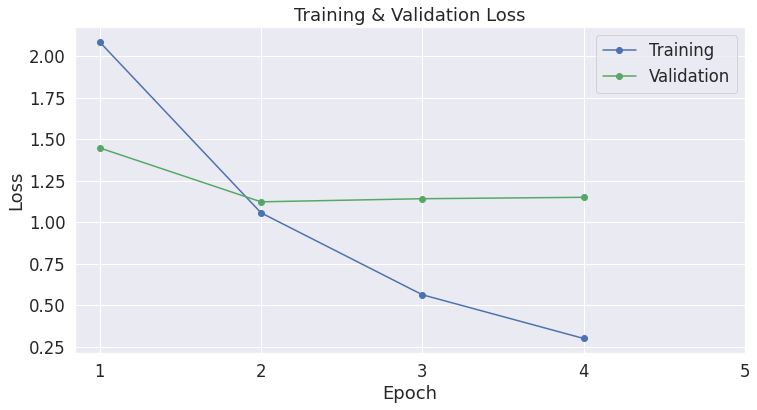

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()

# train persian dataset

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=3e-5, 
                  eps=1e-8)
epochs = 5
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [ ]:
model_path = './drive/MyDrive/data_sets/PERLEX/models/hoshvare_persian_4.model'

In [ ]:
model = BertForSequenceClassification.from_pretrained(config['model_name'], num_labels=len(label2index))
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
import random
import numpy as np

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []


for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        # inputs = {'input_ids':      batch[0],
        #           'attention_mask': batch[1],
        #           'labels':         batch[2],
        #          }  
        

        inputs = {'input_ids':batch[0],
                  'attention_mask': batch[1],
                  # XLM and RoBERTa don't use segment_ids
                  # 'token_type_ids': batch[2],
                  'e1_mask': batch[2],
                  'e2_mask': batch[3],
                  'labels': batch[4]
                  }

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'./drive/MyDrive/data_sets/PERLEX/models/hoshvare_persian_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    

    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tt_accuracy = accuracy_per_class(predictions, true_vals)
    
    tqdm.write(f'accuracy: {tt_accuracy}')
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

    training_stats.append(
        {
            'epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Valid. Accur.': tt_accuracy
        }
    )

    # cmd = input("continue?")
    # if cmd == "No":
      # break



Epoch 1
Training loss: 1.375970909543965
Class: Other
Acc with percent: 0.4673913043478261
Accuracy: 215/460

Class: Message-Topic(e1,e2)
Acc with percent: 0.8837209302325582
Accuracy: 190/215

Class: Message-Topic(e2,e1)
Acc with percent: 0.9038461538461539
Accuracy: 47/52

Class: Product-Producer(e1,e2)
Acc with percent: 0.6666666666666666
Accuracy: 72/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.736
Accuracy: 92/125

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.7272727272727273
Accuracy: 16/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6222222222222222
Accuracy: 84/135

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8458904109589042
Accuracy: 247/292

Class: Cause-Effect(e1,e2)
Acc with percent: 0.8814814814814815
Accuracy: 119/135

Class: Cause-Effect(e2,e1)
Acc with percent: 0.7846153846153846
Accuracy: 153/195

Class: Component-Whole(e1,e2)
Acc with percent: 0.7529411764705882
Accuracy: 128/170

Class: Component-Whole(e2,e1)
Acc with percent: 0.


Epoch 2
Training loss: 0.5430305747275034
Class: Other
Acc with percent: 0.5239130434782608
Accuracy: 241/460

Class: Message-Topic(e1,e2)
Acc with percent: 0.827906976744186
Accuracy: 178/215

Class: Message-Topic(e2,e1)
Acc with percent: 0.8461538461538461
Accuracy: 44/52

Class: Product-Producer(e1,e2)
Acc with percent: 0.8425925925925926
Accuracy: 91/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.816
Accuracy: 102/125

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.6363636363636364
Accuracy: 14/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6074074074074074
Accuracy: 82/135

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8424657534246576
Accuracy: 246/292

Class: Cause-Effect(e1,e2)
Acc with percent: 0.9111111111111111
Accuracy: 123/135

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8769230769230769
Accuracy: 171/195

Class: Component-Whole(e1,e2)
Acc with percent: 0.7176470588235294
Accuracy: 122/170

Class: Component-Whole(e2,e1)
Acc with percent: 0


Epoch 3
Training loss: 0.20910251992507628
Class: Other
Acc with percent: 0.5282608695652173
Accuracy: 243/460

Class: Message-Topic(e1,e2)
Acc with percent: 0.7674418604651163
Accuracy: 165/215

Class: Message-Topic(e2,e1)
Acc with percent: 0.8461538461538461
Accuracy: 44/52

Class: Product-Producer(e1,e2)
Acc with percent: 0.8055555555555556
Accuracy: 87/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.696
Accuracy: 87/125

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.6363636363636364
Accuracy: 14/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6962962962962963
Accuracy: 94/135

Class: Entity-Destination(e1,e2)
Acc with percent: 0.815068493150685
Accuracy: 238/292

Class: Cause-Effect(e1,e2)
Acc with percent: 0.9185185185185185
Accuracy: 124/135

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8717948717948718
Accuracy: 170/195

Class: Component-Whole(e1,e2)
Acc with percent: 0.7823529411764706
Accuracy: 133/170

Class: Component-Whole(e2,e1)
Acc with percent: 0


Epoch 4
Training loss: 0.07150004093932291
Class: Other
Acc with percent: 0.4826086956521739
Accuracy: 222/460

Class: Message-Topic(e1,e2)
Acc with percent: 0.772093023255814
Accuracy: 166/215

Class: Message-Topic(e2,e1)
Acc with percent: 0.8269230769230769
Accuracy: 43/52

Class: Product-Producer(e1,e2)
Acc with percent: 0.75
Accuracy: 81/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.792
Accuracy: 99/125

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.6363636363636364
Accuracy: 14/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.7111111111111111
Accuracy: 96/135

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8732876712328768
Accuracy: 255/292

Class: Cause-Effect(e1,e2)
Acc with percent: 0.9407407407407408
Accuracy: 127/135

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8769230769230769
Accuracy: 171/195

Class: Component-Whole(e1,e2)
Acc with percent: 0.7705882352941177
Accuracy: 131/170

Class: Component-Whole(e2,e1)
Acc with percent: 0.7741935483870


Epoch 5
Training loss: 0.024818175270250487
Class: Other
Acc with percent: 0.4673913043478261
Accuracy: 215/460

Class: Message-Topic(e1,e2)
Acc with percent: 0.8558139534883721
Accuracy: 184/215

Class: Message-Topic(e2,e1)
Acc with percent: 0.8269230769230769
Accuracy: 43/52

Class: Product-Producer(e1,e2)
Acc with percent: 0.8333333333333334
Accuracy: 90/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.808
Accuracy: 101/125

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.6363636363636364
Accuracy: 14/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6962962962962963
Accuracy: 94/135

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8527397260273972
Accuracy: 249/292

Class: Cause-Effect(e1,e2)
Acc with percent: 0.9259259259259259
Accuracy: 125/135

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8564102564102564
Accuracy: 167/195

Class: Component-Whole(e1,e2)
Acc with percent: 0.788235294117647
Accuracy: 134/170

Class: Component-Whole(e2,e1)
Acc with percent:

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
totatl_acc = accuracy_per_class(predictions, true_vals)

Class: Other
Acc with percent: 0.4673913043478261
Accuracy: 215/460

Class: Message-Topic(e1,e2)
Acc with percent: 0.8558139534883721
Accuracy: 184/215

Class: Message-Topic(e2,e1)
Acc with percent: 0.8269230769230769
Accuracy: 43/52

Class: Product-Producer(e1,e2)
Acc with percent: 0.8333333333333334
Accuracy: 90/108

Class: Product-Producer(e2,e1)
Acc with percent: 0.808
Accuracy: 101/125

Class: Instrument-Agency(e1,e2)
Acc with percent: 0.6363636363636364
Accuracy: 14/22

Class: Instrument-Agency(e2,e1)
Acc with percent: 0.6962962962962963
Accuracy: 94/135

Class: Entity-Destination(e1,e2)
Acc with percent: 0.8527397260273972
Accuracy: 249/292

Class: Cause-Effect(e1,e2)
Acc with percent: 0.9259259259259259
Accuracy: 125/135

Class: Cause-Effect(e2,e1)
Acc with percent: 0.8564102564102564
Accuracy: 167/195

Class: Component-Whole(e1,e2)
Acc with percent: 0.788235294117647
Accuracy: 134/170

Class: Component-Whole(e2,e1)
Acc with percent: 0.7354838709677419
Accuracy: 114/155

Class:

In [ ]:
totatl_acc

0.7356920741315893

In [ ]:
f1_score_func(predictions, true_vals)

0.7520320783406157

In [ ]:
import pandas as pd
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,1.38,0.93,0.69
2,0.54,0.89,0.72
3,0.21,0.98,0.72
4,0.07,1.11,0.73
5,0.02,1.16,0.74


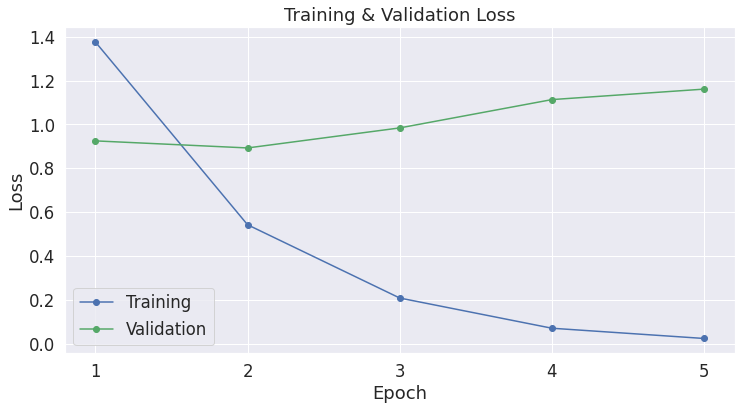

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.show()